In [16]:
# Data handling
import pandas as pd
import numpy as np
import sys
from pathlib import Path

# Add repo root to sys.path
repo_root = Path().resolve().parent
sys.path.append(str(repo_root))

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

from src.dataprep.data_loader import load_housing_data
from src.dataprep.preprocessing import create_preprocessor

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from xgboost import XGBRegressor

In [17]:
data_path = repo_root / "data" / "housing_dataset.csv"
df = load_housing_data(path=data_path)

In [18]:
X = df.drop("price", axis=1)
y = df["price"]

In [19]:
preprocessor = create_preprocessor(X)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
xgb_model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(random_state=42, eval_metric="rmse"))
])

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [22]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
    print(f"R²: {r2_score(y_test, y_pred):.4f}")
    return y_pred

def plot_predictions(y_test, y_pred, title="Predicted vs Actual"):
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(title)
    plt.show()

def plot_residuals(y_test, y_pred):
    residuals = y_test - y_pred
    plt.figure(figsize=(8,6))
    sns.histplot(residuals, kde=True, color='green')
    plt.title("Residuals Distribution")
    plt.xlabel("Residuals")
    plt.show()

MSE: 2042118406144.00
R²: 0.5960


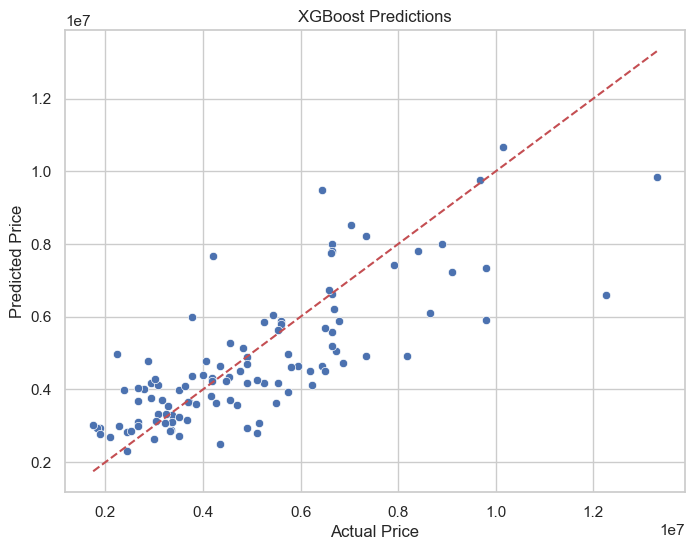

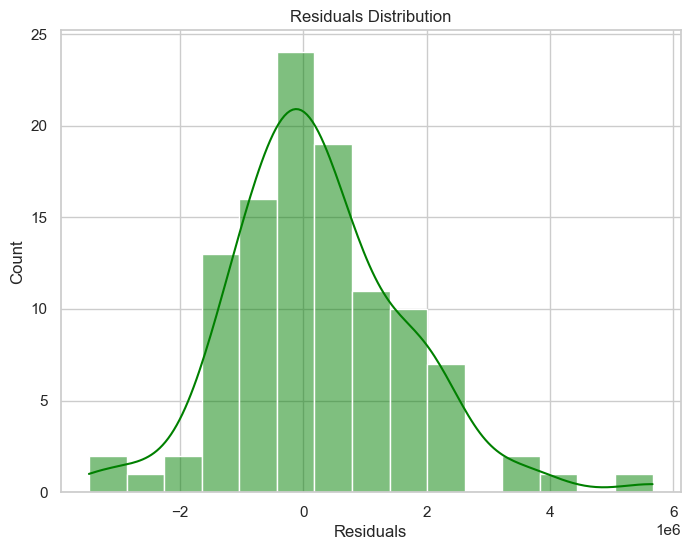

In [23]:
y_pred = evaluate_model(xgb_model, X_test, y_test)
plot_predictions(y_test, y_pred, "XGBoost Predictions")
plot_residuals(y_test, y_pred)

In [24]:
def hyperparameter_tuning(model, param_grid, X_train, y_train, cv=5, scoring="r2"):
    grid = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, n_jobs=-1)
    grid.fit(X_train, y_train)
    print("Best params:", grid.best_params_)
    return grid.best_estimator_

In [25]:
param_grid = {
    "regressor__n_estimators": [500, 1000],
    "regressor__max_depth": [3, 5, 7],
    "regressor__learning_rate": [0.01, 0.05, 0.1],
    "regressor__subsample": [0.7, 0.85, 1.0]
}

In [26]:
best_xgb_model = hyperparameter_tuning(xgb_model, param_grid, X_train, y_train)

Best params: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 5, 'regressor__n_estimators': 500, 'regressor__subsample': 0.7}


MSE: 1773102825472.00
R²: 0.6492


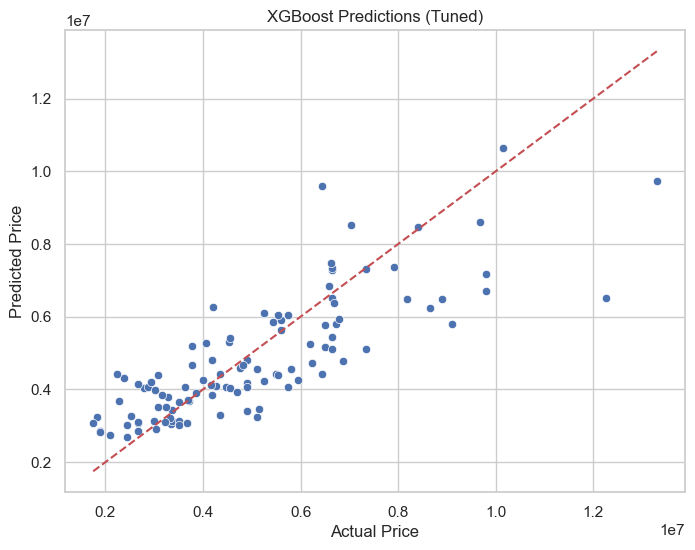

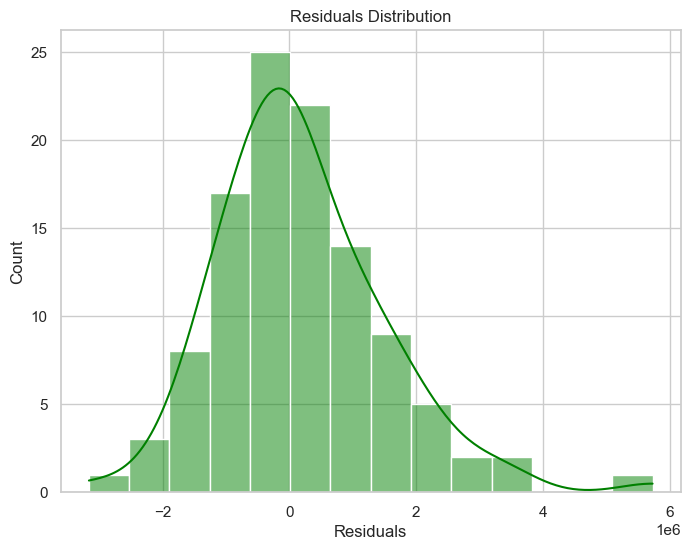

In [27]:
# Evaluate tuned model
y_pred_best = evaluate_model(best_xgb_model, X_test, y_test)
plot_predictions(y_test, y_pred_best, "XGBoost Predictions (Tuned)")
plot_residuals(y_test, y_pred_best)

---